# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder as OrEncoder
from sklearn.feature_selection import chi2

import warnings
warnings.filterwarnings('ignore')

random.seed(44)
sns.set(font_scale = 1.2)
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
# view data
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
# view data
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [4]:
# view data
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


## Step 1: Data Cleaning
**The goal here is to merge at the data frame into a final clean frame, ready for exploratory and predictive analysis**

In [5]:
# function adapted from recommendation notebook
def id_mapper(df):
    coded_dict = dict()
    cter = 1
    id_encoded = []
    
    for val in df['id']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        id_encoded.append(coded_dict[val])
    return id_encoded

In [6]:
# extract the offering channels and convert to binary variables
channels = portfolio.loc[1,'channels']
channels = pd.DataFrame(0, index=np.arange(portfolio.shape[0]), columns=channels)

idx = 0
for row in portfolio['channels']:
    if 'web'in row:
        channels.loc[idx,'web'] = 1
    if 'email'in row:
        channels.loc[idx,'email'] = 1
    if 'mobile'in row:
        channels.loc[idx,'mobile'] = 1
    if 'social'in row:
        channels.loc[idx,'social'] = 1
    idx += 1
del portfolio['channels']
portfolio = pd.concat([portfolio, channels], axis=1, sort=False,)
portfolio

,difficulty,duration,id,offer_type,reward,web,email,mobile,social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,1,1,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,1,0


In [7]:
# rename columns for merging
transcript = transcript.rename(columns = {'person': 'id'})

# merge profile and transcript
df = pd.merge(profile, transcript, on = 'id')

# encode customer id in df2
id_encoded = id_mapper(df)
del df['id']
df['customer_id'] = id_encoded

In [8]:
# unpack the value column
df["amount"] = df["value"].apply(lambda d: d["amount"] if "amount" in d else 0)
df["id"] = df["value"
                   ].apply(lambda d: d["offer id"
                                      ] if "offer id" in d else (d["offer_id"] if "offer_id" in d else 0))
del df['value']    

In [9]:
# How many customers are in the data
df['customer_id'].nunique()

17000

In [10]:
# check percentage of missing values
df.isnull().mean()

age                 0.000000
became_member_on    0.000000
gender              0.110174
income              0.110174
event               0.000000
time                0.000000
customer_id         0.000000
amount              0.000000
id                  0.000000
dtype: float64

In [11]:
# remove rows with missing values
df = df.dropna(axis=0, how='any')

# check dimension
df.shape

(272762, 9)

# Data Visualization

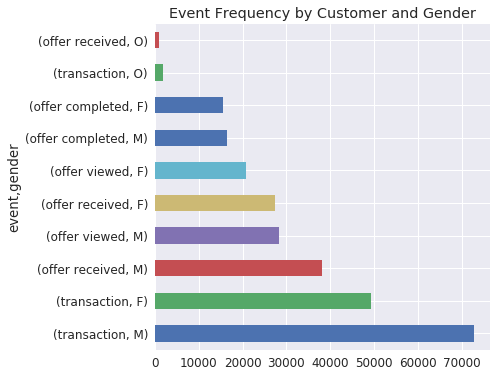

In [12]:
# View event by customer gender
gen = df.groupby(['event','gender'])['customer_id'].count().sort_values(ascending=False).head(10)
gen.plot.barh(figsize =(6,6));
plt.title('Event Frequency by Customer and Gender');

In [13]:
# creating bins
df['income_bracket'] = pd.cut(df['income'], bins=4)
df['transaction_bracket'] = pd.cut(df['amount'], bins=4)

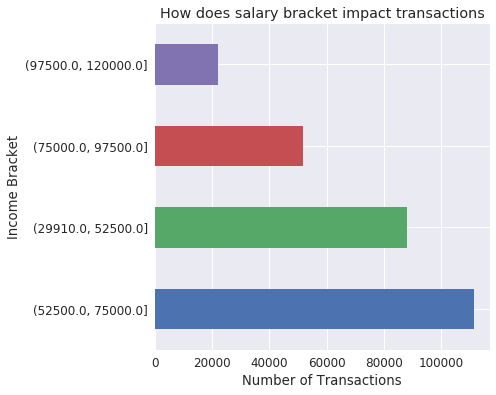

In [14]:
# How does salary bracket impact transactions
cash_relation = df.groupby(['income_bracket'])['transaction_bracket'].count().sort_values(ascending=False)
cash_relation.plot.barh(figsize =(6,6));
plt.title('How does salary bracket impact transactions');
plt.xlabel('Number of Transactions');
plt.ylabel('Income Bracket');

In [15]:
# unstack the event column in the data frame
df = df.groupby(['customer_id','age','gender',
                  'income','became_member_on',
                  'time','id','amount','income_bracket',
                  'transaction_bracket']).event.value_counts().unstack(fill_value = 0).reset_index()

In [16]:
#convert columns to string
df['id'] = df['id'].astype(str)
portfolio['id'] = portfolio['id'].astype(str)


# merge data 
df = pd.merge(df, portfolio, on='id')


# encode customer id in df
id_encoded = id_mapper(df)
del df['id']
df['customer_id'] = id_encoded

In [17]:
df = df.rename(columns={'offer completed': 'offer_completed', 'offer viewed':'offer_viewed',
                        'offer received': 'offer_received'})

In [18]:
# View merged data
df.head()

,customer_id,age,gender,income,became_member_on,time,amount,income_bracket,transaction_bracket,offer_completed,...,offer_viewed,transaction,difficulty,duration,offer_type,reward,web,email,mobile,social
0,1,55,F,112000.0,20170715,408,0.0,"(97500.0, 120000.0]","(-1.062, 265.57]",0,...,0,0,5,7,bogo,5,1,1,1,0
1,1,55,F,112000.0,20170715,528,0.0,"(97500.0, 120000.0]","(-1.062, 265.57]",1,...,0,0,5,7,bogo,5,1,1,1,0
2,1,75,F,100000.0,20170509,0,0.0,"(97500.0, 120000.0]","(-1.062, 265.57]",0,...,0,0,5,7,bogo,5,1,1,1,0
3,1,75,F,100000.0,20170509,6,0.0,"(97500.0, 120000.0]","(-1.062, 265.57]",0,...,1,0,5,7,bogo,5,1,1,1,0
4,1,75,F,100000.0,20170509,132,0.0,"(97500.0, 120000.0]","(-1.062, 265.57]",1,...,0,0,5,7,bogo,5,1,1,1,0


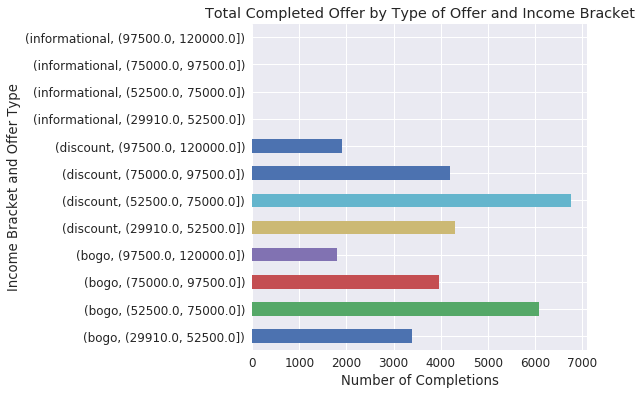

In [19]:
# How does offer type, and income bracket affect offer completion
ofer_type_com = df.groupby(['offer_type', 'income_bracket'])['offer_completed'].sum()
ofer_type_com.plot.barh(figsize =(6,6));
plt.title('Total Completed Offer by Type of Offer and Income Bracket');
plt.xlabel('Number of Completions');
plt.ylabel('Income Bracket and Offer Type');

In [20]:
# check distribution of offers recieved by offer completed
summary = df.groupby(['customer_id',
                      'offer_received'])['offer_completed'].count().sort_values(ascending=False).head(10)

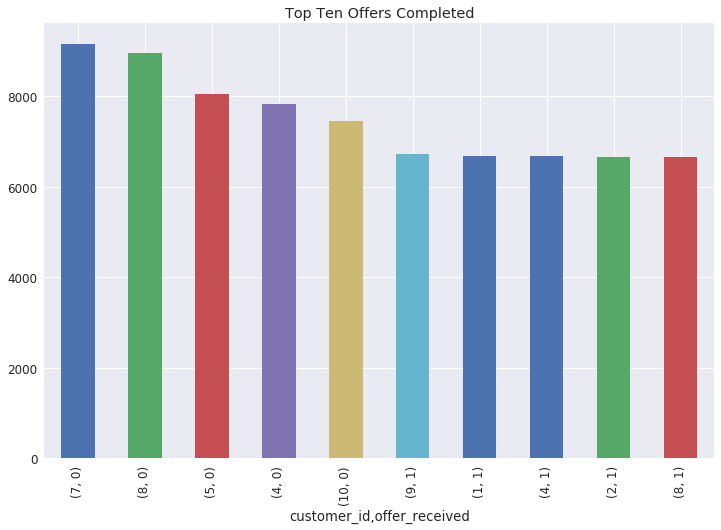

In [21]:
summary.plot.bar(figsize=(12,8));
plt.title('Top Ten Offers Completed');

## Modeling

In [22]:
# Final Preprocessing before modeling
df['class'] = df['offer_completed'].apply(lambda x: 'Yes' if x== 0 else 'No')

In [23]:
# split and prepare the dataset
def split_data(df=df):
    X = df.loc[:, df.columns != 'class'].astype(str)
    del X['offer_completed']
    y = df['class']
    X = X.astype(str)
    
    oe = OrEncoder()
    oe.fit(X)
    X= oe.transform(X)

    le = LabelEncoder()
    le.fit(y)
    y = le.transform(y)

    return X, y

In [24]:
def feature_sel(X, y, classifier, score_func = chi2, n=5, k='all', step=1):
    
    # set feature selector
    selector1 = RFE(classifier, n, step)
    selector2 = SelectKBest(score_func,k)
    
    # combine features
    combined_features = FeatureUnion([("rfe", selector1), 
                                      ("Kbest", selector2)])
    
    # Use combined features to transform dataset and get features
    X_features = combined_features.fit(X, y).transform(X)
    
    return combined_features, X_features

In [25]:
# get data
X,y = split_data()

# create classifier
classificator = RandomForestClassifier()

# get features
combined_features, X_features = feature_sel(X,y,classificator)

print("Combined space has", X_features.shape[1], "features")

Combined space has 25 features


In [26]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Build pipeline
pipeline = Pipeline([
        ('features', combined_features),
        ('clf', classificator)
])

In [27]:
# set parameters
param_grid = dict(features__rfe__n_features_to_select=[4, 8, 12],
                  features__Kbest__k=[5, 10, 20]
                 )

# use grid search to get the best estimator
grid_search = GridSearchCV(pipeline, param_grid=param_grid, verbose=10)
grid_search.fit(X, y)
print(grid_search.best_estimator_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] features__Kbest__k=5, features__rfe__n_features_to_select=4 .....
[CV]  features__Kbest__k=5, features__rfe__n_features_to_select=4, score=0.959, total=  18.8s
[CV] features__Kbest__k=5, features__rfe__n_features_to_select=4 .....


[Parallel(n_jobs=None)]: Done   1 out of   1 | elapsed:   18.8s remaining:    0.0s


[CV]  features__Kbest__k=5, features__rfe__n_features_to_select=4, score=0.945, total=  15.0s
[CV] features__Kbest__k=5, features__rfe__n_features_to_select=4 .....


[Parallel(n_jobs=None)]: Done   2 out of   2 | elapsed:   33.8s remaining:    0.0s


[CV]  features__Kbest__k=5, features__rfe__n_features_to_select=4, score=0.743, total=  16.7s
[CV] features__Kbest__k=5, features__rfe__n_features_to_select=8 .....


[Parallel(n_jobs=None)]: Done   3 out of   3 | elapsed:   50.5s remaining:    0.0s


[CV]  features__Kbest__k=5, features__rfe__n_features_to_select=8, score=0.964, total=  14.9s
[CV] features__Kbest__k=5, features__rfe__n_features_to_select=8 .....


[Parallel(n_jobs=None)]: Done   4 out of   4 | elapsed:  1.1min remaining:    0.0s


[CV]  features__Kbest__k=5, features__rfe__n_features_to_select=8, score=0.733, total=  11.9s
[CV] features__Kbest__k=5, features__rfe__n_features_to_select=8 .....


[Parallel(n_jobs=None)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s


[CV]  features__Kbest__k=5, features__rfe__n_features_to_select=8, score=0.770, total=  13.5s
[CV] features__Kbest__k=5, features__rfe__n_features_to_select=12 ....


[Parallel(n_jobs=None)]: Done   6 out of   6 | elapsed:  1.5min remaining:    0.0s


[CV]  features__Kbest__k=5, features__rfe__n_features_to_select=12, score=0.965, total=  10.5s
[CV] features__Kbest__k=5, features__rfe__n_features_to_select=12 ....


[Parallel(n_jobs=None)]: Done   7 out of   7 | elapsed:  1.7min remaining:    0.0s


[CV]  features__Kbest__k=5, features__rfe__n_features_to_select=12, score=0.731, total=   8.5s
[CV] features__Kbest__k=5, features__rfe__n_features_to_select=12 ....


[Parallel(n_jobs=None)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s


[CV]  features__Kbest__k=5, features__rfe__n_features_to_select=12, score=0.704, total=   9.9s
[CV] features__Kbest__k=10, features__rfe__n_features_to_select=4 ....


[Parallel(n_jobs=None)]: Done   9 out of   9 | elapsed:  2.0min remaining:    0.0s


[CV]  features__Kbest__k=10, features__rfe__n_features_to_select=4, score=0.965, total=  18.2s
[CV] features__Kbest__k=10, features__rfe__n_features_to_select=4 ....
[CV]  features__Kbest__k=10, features__rfe__n_features_to_select=4, score=0.660, total=  14.7s
[CV] features__Kbest__k=10, features__rfe__n_features_to_select=4 ....
[CV]  features__Kbest__k=10, features__rfe__n_features_to_select=4, score=0.728, total=  16.7s
[CV] features__Kbest__k=10, features__rfe__n_features_to_select=8 ....
[CV]  features__Kbest__k=10, features__rfe__n_features_to_select=8, score=0.965, total=  14.4s
[CV] features__Kbest__k=10, features__rfe__n_features_to_select=8 ....
[CV]  features__Kbest__k=10, features__rfe__n_features_to_select=8, score=0.721, total=  11.8s
[CV] features__Kbest__k=10, features__rfe__n_features_to_select=8 ....
[CV]  features__Kbest__k=10, features__rfe__n_features_to_select=8, score=0.597, total=  13.8s
[CV] features__Kbest__k=10, features__rfe__n_features_to_select=12 ...
[CV]

[Parallel(n_jobs=None)]: Done  27 out of  27 | elapsed:  5.9min finished


Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('rfe',
                                                 RFE(estimator=RandomForestClassifier(bootstrap=True,
                                                                                      class_weight=None,
                                                                                      criterion='gini',
                                                                                      max_depth=None,
                                                                                      max_features='auto',
                                                                                      max_leaf_nodes=None,
                                                                                      min_impurity_decrease=0.0,
                                                                                      min_impurity_split=None,

##  Model Training

In [28]:
# get the best features with the tuned parameters
combined_features_2, X_features_2 = feature_sel(X,y,classificator,n=12,k=10 )
    
    
# re-Build pipeline
pipeline = Pipeline([
        ('features', combined_features_2),
        ('clf', classificator)
])

#train classifier
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('rfe',
                                                 RFE(estimator=RandomForestClassifier(bootstrap=True,
                                                                                      class_weight=None,
                                                                                      criterion='gini',
                                                                                      max_depth=None,
                                                                                      max_features='auto',
                                                                                      max_leaf_nodes=None,
                                                                                      min_impurity_decrease=0.0,
                                                                                      min_impurity_split=None,

## Model Testing and Evaluation

In [29]:
# predict on test data
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

print("Accuracy: {0:.3f}".format((y_test == y_pred).mean()))


              precision    recall  f1-score   support

           0       0.98      0.88      0.93      9560
           1       0.96      0.99      0.98     30543

    accuracy                           0.97     40103
   macro avg       0.97      0.94      0.95     40103
weighted avg       0.97      0.97      0.97     40103

[[ 8391  1169]
 [  154 30389]]
Accuracy: 0.967


** this model performs very well**